# Web Scraping by BeautifulSoup, Selenium-wire and Data Analytics - PodBean
    Contributed to Skooldio
---
##### <u>**Objective** : Web scrape Podbean and data analysis for creating marketing content.</u><br>

*by Patcharanat P.*<br>

**Data: [Website Podbean](https://eighthalf.podbean.com/)**<br>

### Table of contents
* Import Library
* Data Understanding
* Web Scraping
* Data Cleaning and Transformation
* Exploratory Data Analysis

---

### Import Library

In [1]:
import numpy as np
import pandas as pd

from bs4 import BeautifulSoup
import requests
from seleniumwire import webdriver
import json

import re

import matplotlib.pyplot as plt
import seaborn as sns

---

### Data Understanding

    Data consists of 2 sources, one is provided by Official website Podbean as XML format, but the data is not included what I preferred. So, more data is required by web scraping method which is another data source. After collecting from both sources, Integration is required to make dataset completed and valid.

---

### Web Scraping

##### **Podbean (XML)**

Due to pandas library `pd.read_xml()` giving a false result, so BeautifulSoup library was used instead.

In [40]:
url_xml = "https://feed.podbean.com/eighthalf/feed.xml"

content_xml = requests.get(url_xml)
soup_xml = BeautifulSoup(content_xml.text, 'xml')

xml_dict = {} # This dict will be used for mapping data to HTML,AJAX method and aggregated into one DataFrame
for e in soup_xml.find_all('item') : # get all tags 'item'
    temp_url = e.find_next('enclosure')['url'] # get url link to each podcast
    author = e.find_next('itunes:author').text # get the author name
    duration = e.find_next('itunes:duration').text # get duration of each podcast

    # Extract Podcast ID from each URL by regular expression
    test_list = [] # temporary list for extracting podcast ID from URL
    for m in re.finditer('/', temp_url):
        test_list.append(m) # collect all index of '/' string
    ind = test_list[-1].end() # choose the last index of '/'
    temp_id = temp_url[ind:] # slice to get all string after the last '/'
    xml_dict[temp_id] = [author, duration] # Collect ID as key and collect author, duration as list value
len(xml_dict.keys()) # print number of IDs

999

##### **Podbean (HTML, AJAX)**

In [41]:
data = {'ID': [],
        'title': [],
        'date': [],
        'description': []
        } # dict for collecting data
total_download = {}

i = 1
while i < 10_000 : # end at page 124 approximately
    if i < 2 :
        url = "https://eighthalf.podbean.com"
    else :
        url = f"https://eighthalf.podbean.com/page/{i}/"
    i+= 1

    html = requests.get(url)

    if html.status_code == 200 :
    
        soup = BeautifulSoup(html.text, 'html.parser')

        # Retrive Data from AJAX Requests (API Calls) using Selenium-wire.
        driver = webdriver.Chrome()

        driver.get(url)

        # Access requests via attribute `requests` 
        for request in driver.requests:
            if request.response:
                if 'https://www.podbean.com/api2/public/filesPlays?' in request.url :
                    api_url = request.url # collect unique api url everytime new page load.
                    # print(api_url)
                    break # found api url

        driver.quit()

        # access data in api_url
        response = requests.get(api_url)
        download_dict = json.loads(response.text)

        # Collect progressing data
        for e in soup.find_all('div', class_='entry') : # each e is a tag <div> for each podcast
            
            # Collect BeautifulSoup Data
            data['ID'].append(e.find_next('span', class_='hits wait-load')['data-file'])
            data['title'].append(e.h2.text)
            data['date'].append(e.find(class_='day').text)
            data['description'].append(e.find(class_='date').find_next('p').text)
            # break

        # Collect Selenium Data
        total_download.update(download_dict['data']) # update dict by collected data
    else :
        break # will break when no more podcast is shown


In [42]:
df = pd.DataFrame(data) # Transform data from scraping HTML, AJAX webpages to DataFrame

    Aggregate data from XML method and HTML, AJAX method into one DataFrame.

In [43]:
df['download'] = np.nan
df['author'] = np.nan
df['duration'] = np.nan

for index, row in df.iterrows():
    # HTML: Insert download reccord
    ID = df['ID'][index]
    if ID in total_download :
        df['download'][index] = total_download[row['ID']]
    else :
        df['download'][index] = np.nan
    
    # XML: Insert author and duration
    if ID in xml_dict.keys() :
        df['author'][index] = xml_dict[ID][0]
        df['duration'][index] = xml_dict[ID][1]
    else :
        df['author'][index] = np.nan
        df['duration'][index] = np.nan
df

C:\Users\patch\AppData\Local\Temp\ipykernel_12228\3496304095.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['download'][index] = total_download[row['ID']]
C:\Users\patch\AppData\Local\Temp\ipykernel_12228\3496304095.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['author'][index] = xml_dict[ID][0]
c:\Users\patch\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returnin

,ID,title,date,description,download,author,duration
0,85_EP1226-_3_2_2562_BE_1134b0eeh.mp3,8 1/2 EP1226 - Product Manager ที่ดีต้องมีอะไร...,"July 26, 2022",เรื่องราว คำแนะนำ จาก Tony Fadell ผู้สร้าง iPo...,750.0,ต้อง กวีวุฒิ,09:51
1,85_EP1225-_3_2_2562_BE_1134afgq7.mp3,8 1/2 EP1225 - แบบทดสอบ DISC และ e-color ใช้ยังไง,"July 25, 2022",team building แบบง่ายๆ ให้คนทำงานร่วมกัน,1635.0,ต้อง กวีวุฒิ,07:36
2,85_EP1224-_3_2_2562_BE_11348re8b.mp3,8 1/2 EP1224 - วิเคราะห์เศรษฐกิจโลกแบบเข้าใจง่...,"July 24, 2022",เศรษฐกิจโลกแบบเข้าใจง่ายๆ,2684.0,ต้อง กวีวุฒิ,57:01
3,85_EP1223-_3_2_2562_BE_11349wxra.mp3,8 1/2 EP1223 - ขายของแบบ Steve Jobs,"July 23, 2022",เรื่องราว คำแนะนำ จาก Tony Fadell ผู้สร้าง iPo...,2275.0,ต้อง กวีวุฒิ,08:31
4,85_EP1222-_3_2_2562_BE_11348n2o2.mp3,8 1/2 EP1222 - สร้างผลิตภัณฑ์ที่ดี เริ่มต้นที่...,"July 22, 2022",เรื่องราว คำแนะนำ จาก Tony Fadell ผู้สร้าง iPo...,2186.0,ต้อง กวีวุฒิ,08:01
...,...,...,...,...,...,...,...
1241,stream_574653732-user-643868388-ep15.mp3,แปดบรรทัดครึ่ง EP15 - สร้างนวัตกรรม เริ่มต้นอย...,"February 15, 2019",ม้าที่วิ่งเร็ว คุณอยากได้มั้ย ?\n,3408.0,NaN,NaN
1242,stream_574647669-user-643868388-ep14-steve-job...,แปดบรรทัดครึ่ง EP14 - Steve Jobs ทำอะไร เมื่อก...,"February 14, 2019",Mission และ Vision ต่างกันอย่างไร\n,3574.0,NaN,NaN
1243,stream_573607374-user-643868388-ep13-20-70-10-...,แปดบรรทัดครึ่ง EP13 - แบ่งคนเป็น 20-70-10 แบบ GE,"February 13, 2019",ยุติธรรม กับ เท่าเทียม เหมือนกันหรือไม่ ?\n,3886.0,NaN,NaN
1244,stream_573601638-user-643868388-ep12-netflix.mp3,แปดบรรทัดครึ่ง EP12 - บริหารทีมแบบ Netflix ทำอ...,"February 12, 2019",บริหารทีมแบบครอบครัว ดีจริงหรือ ?\n,4501.0,NaN,NaN


    Export file as csv for data analysis in further.

In [44]:
# due to extremely long run-time, so I'll save data as csv file for next time data analysis
df.to_csv('8half_dataset.csv')

### Data Cleaning and Transformation

In [ ]:
df = pd.read_csv('8half_dataset.csv')
df.head()

,Unnamed: 0,ID,title,date,description,download,author,duration
0,0,85_EP1226-_3_2_2562_BE_1134b0eeh.mp3,8 1/2 EP1226 - Product Manager ที่ดีต้องมีอะไร...,"July 26, 2022",เรื่องราว คำแนะนำ จาก Tony Fadell ผู้สร้าง iPo...,750.0,ต้อง กวีวุฒิ,09:51
1,1,85_EP1225-_3_2_2562_BE_1134afgq7.mp3,8 1/2 EP1225 - แบบทดสอบ DISC และ e-color ใช้ยังไง,"July 25, 2022",team building แบบง่ายๆ ให้คนทำงานร่วมกัน,1635.0,ต้อง กวีวุฒิ,07:36
2,2,85_EP1224-_3_2_2562_BE_11348re8b.mp3,8 1/2 EP1224 - วิเคราะห์เศรษฐกิจโลกแบบเข้าใจง่...,"July 24, 2022",เศรษฐกิจโลกแบบเข้าใจง่ายๆ,2684.0,ต้อง กวีวุฒิ,57:01
3,3,85_EP1223-_3_2_2562_BE_11349wxra.mp3,8 1/2 EP1223 - ขายของแบบ Steve Jobs,"July 23, 2022",เรื่องราว คำแนะนำ จาก Tony Fadell ผู้สร้าง iPo...,2275.0,ต้อง กวีวุฒิ,08:31
4,4,85_EP1222-_3_2_2562_BE_11348n2o2.mp3,8 1/2 EP1222 - สร้างผลิตภัณฑ์ที่ดี เริ่มต้นที่...,"July 22, 2022",เรื่องราว คำแนะนำ จาก Tony Fadell ผู้สร้าง iPo...,2186.0,ต้อง กวีวุฒิ,08:01


    Check Null Value

In [46]:
df.isnull().sum()

Unnamed: 0       0
ID               0
title            0
date             0
description      0
download         0
author         244
duration       244
dtype: int64

    Transform duration to second

In [47]:
df['duration_sec'] = np.nan
df['year'] = np.nan
df['month'] = np.nan

for index, row in df.iterrows():
    # duration_sec
    temp_duration = str(row['duration']).split(sep=':')
    if len(temp_duration) == 3:
        df['duration_sec'][index] = (int(temp_duration[0])*60 + int(temp_duration[1]))*60 + int(temp_duration[2])
    elif len(temp_duration) == 2:
        df['duration_sec'][index] = int(temp_duration[0])*60 + int(temp_duration[1])
    
    # year & month columns
    date_list = str(row['date']).split()
    df['month'][index] = date_list[0]
    df['year'][index] = str(int(date_list[2]))
df

C:\Users\patch\AppData\Local\Temp\ipykernel_12228\317598693.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['duration_sec'][index] = int(temp_duration[0])*60 + int(temp_duration[1])
C:\Users\patch\AppData\Local\Temp\ipykernel_12228\317598693.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'][index] = date_list[0]
c:\Users\patch\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

,Unnamed: 0,ID,title,date,description,download,author,duration,duration_sec,year,month
0,0,85_EP1226-_3_2_2562_BE_1134b0eeh.mp3,8 1/2 EP1226 - Product Manager ที่ดีต้องมีอะไร...,"July 26, 2022",เรื่องราว คำแนะนำ จาก Tony Fadell ผู้สร้าง iPo...,750.0,ต้อง กวีวุฒิ,09:51,591.0,2022.0,July
1,1,85_EP1225-_3_2_2562_BE_1134afgq7.mp3,8 1/2 EP1225 - แบบทดสอบ DISC และ e-color ใช้ยังไง,"July 25, 2022",team building แบบง่ายๆ ให้คนทำงานร่วมกัน,1635.0,ต้อง กวีวุฒิ,07:36,456.0,2022.0,July
2,2,85_EP1224-_3_2_2562_BE_11348re8b.mp3,8 1/2 EP1224 - วิเคราะห์เศรษฐกิจโลกแบบเข้าใจง่...,"July 24, 2022",เศรษฐกิจโลกแบบเข้าใจง่ายๆ,2684.0,ต้อง กวีวุฒิ,57:01,3421.0,2022.0,July
3,3,85_EP1223-_3_2_2562_BE_11349wxra.mp3,8 1/2 EP1223 - ขายของแบบ Steve Jobs,"July 23, 2022",เรื่องราว คำแนะนำ จาก Tony Fadell ผู้สร้าง iPo...,2275.0,ต้อง กวีวุฒิ,08:31,511.0,2022.0,July
4,4,85_EP1222-_3_2_2562_BE_11348n2o2.mp3,8 1/2 EP1222 - สร้างผลิตภัณฑ์ที่ดี เริ่มต้นที่...,"July 22, 2022",เรื่องราว คำแนะนำ จาก Tony Fadell ผู้สร้าง iPo...,2186.0,ต้อง กวีวุฒิ,08:01,481.0,2022.0,July
...,...,...,...,...,...,...,...,...,...,...,...
1241,1241,stream_574653732-user-643868388-ep15.mp3,แปดบรรทัดครึ่ง EP15 - สร้างนวัตกรรม เริ่มต้นอย...,"February 15, 2019",ม้าที่วิ่งเร็ว คุณอยากได้มั้ย ?\n,3408.0,NaN,NaN,NaN,2019.0,February
1242,1242,stream_574647669-user-643868388-ep14-steve-job...,แปดบรรทัดครึ่ง EP14 - Steve Jobs ทำอะไร เมื่อก...,"February 14, 2019",Mission และ Vision ต่างกันอย่างไร\n,3574.0,NaN,NaN,NaN,2019.0,February
1243,1243,stream_573607374-user-643868388-ep13-20-70-10-...,แปดบรรทัดครึ่ง EP13 - แบ่งคนเป็น 20-70-10 แบบ GE,"February 13, 2019",ยุติธรรม กับ เท่าเทียม เหมือนกันหรือไม่ ?\n,3886.0,NaN,NaN,NaN,2019.0,February
1244,1244,stream_573601638-user-643868388-ep12-netflix.mp3,แปดบรรทัดครึ่ง EP12 - บริหารทีมแบบ Netflix ทำอ...,"February 12, 2019",บริหารทีมแบบครอบครัว ดีจริงหรือ ?\n,4501.0,NaN,NaN,NaN,2019.0,February


    Transform Date Format

In [48]:
month_dict = {
    'January': '01',
    'February': '02',
    'March': '03',
    'April': '04',
    'May': '05',
    'June': '06',
    'July': '07',
    'August': '08',
    'September': '09',
    'October': '10',
    'November': '11',
    'December': '12'
}

In [49]:
df.replace({'date': month_dict}, inplace=True, regex=True)
df['date'].replace(',', '', inplace=True, regex=True)
df['date'].replace(' ', '-', inplace=True, regex=True)
df['date'] = pd.to_datetime(df['date'])

,Unnamed: 0,ID,title,date,description,download,author,duration,duration_sec,year,month
0,0,85_EP1226-_3_2_2562_BE_1134b0eeh.mp3,8 1/2 EP1226 - Product Manager ที่ดีต้องมีอะไร...,07-26-2022,เรื่องราว คำแนะนำ จาก Tony Fadell ผู้สร้าง iPo...,750.0,ต้อง กวีวุฒิ,09:51,591.0,2022.0,July
1,1,85_EP1225-_3_2_2562_BE_1134afgq7.mp3,8 1/2 EP1225 - แบบทดสอบ DISC และ e-color ใช้ยังไง,07-25-2022,team building แบบง่ายๆ ให้คนทำงานร่วมกัน,1635.0,ต้อง กวีวุฒิ,07:36,456.0,2022.0,July
2,2,85_EP1224-_3_2_2562_BE_11348re8b.mp3,8 1/2 EP1224 - วิเคราะห์เศรษฐกิจโลกแบบเข้าใจง่...,07-24-2022,เศรษฐกิจโลกแบบเข้าใจง่ายๆ,2684.0,ต้อง กวีวุฒิ,57:01,3421.0,2022.0,July
3,3,85_EP1223-_3_2_2562_BE_11349wxra.mp3,8 1/2 EP1223 - ขายของแบบ Steve Jobs,07-23-2022,เรื่องราว คำแนะนำ จาก Tony Fadell ผู้สร้าง iPo...,2275.0,ต้อง กวีวุฒิ,08:31,511.0,2022.0,July
4,4,85_EP1222-_3_2_2562_BE_11348n2o2.mp3,8 1/2 EP1222 - สร้างผลิตภัณฑ์ที่ดี เริ่มต้นที่...,07-22-2022,เรื่องราว คำแนะนำ จาก Tony Fadell ผู้สร้าง iPo...,2186.0,ต้อง กวีวุฒิ,08:01,481.0,2022.0,July
...,...,...,...,...,...,...,...,...,...,...,...
1241,1241,stream_574653732-user-643868388-ep15.mp3,แปดบรรทัดครึ่ง EP15 - สร้างนวัตกรรม เริ่มต้นอย...,02-15-2019,ม้าที่วิ่งเร็ว คุณอยากได้มั้ย ?\n,3408.0,NaN,NaN,NaN,2019.0,February
1242,1242,stream_574647669-user-643868388-ep14-steve-job...,แปดบรรทัดครึ่ง EP14 - Steve Jobs ทำอะไร เมื่อก...,02-14-2019,Mission และ Vision ต่างกันอย่างไร\n,3574.0,NaN,NaN,NaN,2019.0,February
1243,1243,stream_573607374-user-643868388-ep13-20-70-10-...,แปดบรรทัดครึ่ง EP13 - แบ่งคนเป็น 20-70-10 แบบ GE,02-13-2019,ยุติธรรม กับ เท่าเทียม เหมือนกันหรือไม่ ?\n,3886.0,NaN,NaN,NaN,2019.0,February
1244,1244,stream_573601638-user-643868388-ep12-netflix.mp3,แปดบรรทัดครึ่ง EP12 - บริหารทีมแบบ Netflix ทำอ...,02-12-2019,บริหารทีมแบบครอบครัว ดีจริงหรือ ?\n,4501.0,NaN,NaN,NaN,2019.0,February


### Exploratory Data Analysis

In [51]:
most_download_index = df['download'].sort_values(ascending=False).index
top = df.iloc[most_download_index,].head(10)
top

,Unnamed: 0,ID,title,date,description,download,author,duration,duration_sec,year,month
505,505,85_EPL37-_Top_Jirayut8t9iq.mp3,แปดบรรทัดครึ่ง EP#719: คุยกับ “ทอป จิรายุส” CE...,2021-02-26,แนวคิดการบริหารองค์กรยุคใหม่,10904.0,ต้อง กวีวุฒิ,01:50:01,6601.0,2021.0,February
579,579,85_EPL28-_No_Rules_Rules9nb3a.mp3,8.5 เล่าหนังสือ #1 - No Rules Rules ของ CEO Ne...,2020-12-10,คัมภีร์ Innovation ที่ผู้บริหารไม่ค่อยมีเวลาคว...,10615.0,ต้อง กวีวุฒิ,01:28:54,5334.0,2020.0,December
316,316,85_EP909-_3_2_2562_BE_1134brv2d.mp3,8 1/2 EP909- คุยกับ หนึ่ง ถิรนันท์ COO แห่ง MO...,2021-09-07,ผู้นำยุคใหม่ มีแนวคิดอย่างไร,10303.0,ต้อง กวีวุฒิ,01:10:23,4223.0,2021.0,September
526,526,85_EPL34-_How_to_Lead95k2y.mp3,แปดบรรทัดครึ่ง EP698 - เล่าหนังสือ “How to Lead”,2021-02-04,คนเก่งๆเขานำคนอย่างไร,10133.0,ต้อง กวีวุฒิ,01:09:49,4189.0,2021.0,February
281,281,85_EP945-_3_2_2562_BE_11349czy2.mp3,คุยกับพี่ป็อบ อภิวุฒิ ผู้ก่อตั้ง Slingshot Gro...,2021-10-13,ระทม รันทด ระทึก รอดทุกข์,10084.0,ต้อง กวีวุฒิ,01:15:24,4524.0,2021.0,October
261,261,85_EP965-_3_2_2562_BE_113463euh.mp3,8 1/2 EP935 - คุยกับพี่เจี๊ยบ ปฐมา หัวเรือใหญ่...,2021-11-02,"If you want to have something you never had, y...",9978.0,ต้อง กวีวุฒิ,01:19:45,4785.0,2021.0,November
220,220,85_EP1006-_3_2_2562_BE_11348c02m.mp3,8 1/2 EP1006 -คุยกับพี่อ๋อง Nasket เจ้าของหนัง...,2021-12-14,8 สิ่งที่คนเก่งมีร่วมกัน มีอะไรบ้าง,9777.0,ต้อง กวีวุฒิ,01:18:22,4702.0,2021.0,December
310,310,85_EP915-_3_2_2562_BE_1134bponh.mp3,8 1/2 EP915- คุยกับดร.ชวพล President of Huawei...,2021-09-13,ทำไม JD จึงจำเป็นน้อยลง,9642.0,ต้อง กวีวุฒิ,01:04:32,3872.0,2021.0,September
324,324,85_EP901-_3_2_2562_BE_11348kcwu.mp3,8 1/2 EP961- คุยเรื่อง “ผู้นำในภาวะวิกฤต” กับ ...,2021-08-30,เมื่อเจอวิกฤต ผู้นำต้องเป็นอย่างไร,9628.0,ต้อง กวีวุฒิ,01:05:52,3952.0,2021.0,August
268,268,85_EP958-_3_2_2562_BE_11347s57b.mp3,8 1/2 EP958 - คุยกับอดีต CEO ปตท. คุณเทวินทร์ ...,2021-10-26,บริหารงานแบบ CEO รุ่นเก๋า มีอะไรบ้าง,9592.0,ต้อง กวีวุฒิ,01:14:24,4464.0,2021.0,October


In [52]:
df.loc[df['download'] == df['download'].min()]

,Unnamed: 0,ID,title,date,description,download,author,duration,duration_sec,year,month
1109,1109,stream_644074287-user-643868388-ep147.m4a,แปดบรรทัดครึ่ง EP147 - ไอเดียดี สื่อสารยังไง ใ...,2019-07-01,แรงม้า เกิดขึ้น ยังไง\n,340.0,NaN,NaN,NaN,2019.0,July


In [53]:
df['download'].mean()

4849.4406099518455

In [54]:
df['title'].str.contains('Skooldio').any()

False

In [55]:
df['author'].value_counts()

ต้อง กวีวุฒิ    1002
Name: author, dtype: int64

In [65]:
duration_mean = df['duration_sec'].mean()
print('hour: ', str((duration_mean // 60) // 60))
print('min: ', str((duration_mean // 60) % 60))
print('sec: ', str(duration_mean % 60))
print(duration_mean)

hour:  0.0
min:  14.0
sec:  28.76447105788418
868.7644710578842


In [58]:
df.loc[df['duration_sec'] == df['duration_sec'].max()]

,Unnamed: 0,ID,title,date,description,download,author,duration,duration_sec,year,month
505,505,85_EPL37-_Top_Jirayut8t9iq.mp3,แปดบรรทัดครึ่ง EP#719: คุยกับ “ทอป จิรายุส” CE...,2021-02-26,แนวคิดการบริหารองค์กรยุคใหม่,10904.0,ต้อง กวีวุฒิ,01:50:01,6601.0,2021.0,February


In [59]:
high_duration = df.loc[df['duration_sec'] > 2700]
low_duration = df.loc[df['duration_sec'] < 2700]
high_duration

,Unnamed: 0,ID,title,date,description,download,author,duration,duration_sec,year,month
2,2,85_EP1224-_3_2_2562_BE_11348re8b.mp3,8 1/2 EP1224 - วิเคราะห์เศรษฐกิจโลกแบบเข้าใจง่...,2022-07-24,เศรษฐกิจโลกแบบเข้าใจง่ายๆ,2684.0,ต้อง กวีวุฒิ,57:01,3421.0,2022.0,July
19,19,85_EP1207-_3_2_2562_BE_1134bmay1.mp3,TUXSA x 8 1/2 EP1207 - คุยกับพี่แต๋ม ศุภจี CEO...,2022-07-07,เรียนรู้ตลอดเวลา เพื่อปรับปรุง เปลี่ยนแปลง,4471.0,ต้อง กวีวุฒิ,59:38,3578.0,2022.0,July
26,26,85_EP1200-_3_2_2562_BE_11346orwi.mp3,8 1/2 EP1200 - คุยกับพี่โจ้ ธนา เรื่องชีวิต ชีวิต,2022-06-30,เกร็ดจากหนังสือขายดี แด่คลื่นเล็กๆในมหาสมุทร,5973.0,ต้อง กวีวุฒิ,01:07:56,4076.0,2022.0,June
67,67,85_EP1159-_3_2_2562_BE_1134awmg2.mp3,8 1/2 EP1159 - คุยกับคุณธี ผู้ก่อตั้ง Sertis เ...,2022-05-18,วัฒนธรรมองค์กรเทคที่สำคัญมีอะไรบ้าง,6146.0,ต้อง กวีวุฒิ,01:04:34,3874.0,2022.0,May
84,84,85_EP1142-_3_2_2562_BE_1134bp1o5.mp3,8 1/2 EP1142 - คุยกับผู้ก่อตั้ง looloo Tech บร...,2022-05-01,คนเก่งๆต้องการทำงานแบบไหน,6110.0,ต้อง กวีวุฒิ,01:04:46,3886.0,2022.0,May
...,...,...,...,...,...,...,...,...,...,...,...
747,747,85_EPL5-__9kld6.mp3,ไลฟ์ #5 คุยกับ อจ. ชัชชาติ สิทธิพันธ์ - ในฐานะ...,2020-07-02,เมืองในอนาคตจะเป็นอย่างไร,5941.0,ต้อง กวีวุฒิ,01:00:23,3623.0,2020.0,July
749,749,85_EPL4-_KBTG_81976.mp3,ไลฟ์ #4 คุยกับ กระทิง เรืองโรจน์ พูนผล - ในฐาน...,2020-07-01,คุยเรื่องการบริหารองค์กรเทคโนโลยี นวัตกรรม,5849.0,ต้อง กวีวุฒิ,01:07:56,4076.0,2020.0,July
751,751,85_EPL3-__98fx0.mp3,ไลฟ์ #3 คุยกับโจ้ ธนา เธียรอัจฉริยะ - การบริหา...,2020-06-30,ชีวิตจะวางแผนได้จริงหรือไม่,6399.0,ต้อง กวีวุฒิ,01:18:53,4733.0,2020.0,June
753,753,85_EPL2-__99g9k.mp3,ไลฟ์ #2 คุยกับแทป รวิศ หาญอุตสาหะ - ในฐานะผู้บ...,2020-06-29,การบริหารงานแบบ รวิศ หาญอุตสาหะ,6076.0,ต้อง กวีวุฒิ,01:16:08,4568.0,2020.0,June


In [60]:
df['year'].value_counts()

2020.0    367
2021.0    359
2019.0    317
2022.0    203
Name: year, dtype: int64

In [61]:
# filter substrings

df_filtered_1 = df[df['title'].str.contains('คุย', na=False)]
df_filtered_2 = df_filtered_1[df['title'].str.contains('กับ')]
# https://stackoverflow.com/questions/11350770/filter-pandas-dataframe-by-substring-criteria

C:\Users\patch\AppData\Local\Temp\ipykernel_12228\1259246472.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_filtered_2 = df_filtered_1[df['title'].str.contains('กับ')]


5. Visualization

In [62]:
sns.set(style='dark')

from matplotlib.ticker import FuncFormatter

def hundred_thousand(x, pos):
    'The two args are the value and tick position'
    return '%10.0dK' % (x*1e-3)

formatter = FuncFormatter(hundred_thousand)

# custom suffix yticks: https://matplotlib.org/2.0.2/examples/pylab_examples/custom_ticker1.html
# formatting: https://thepythonguru.com/python-string-formatting/

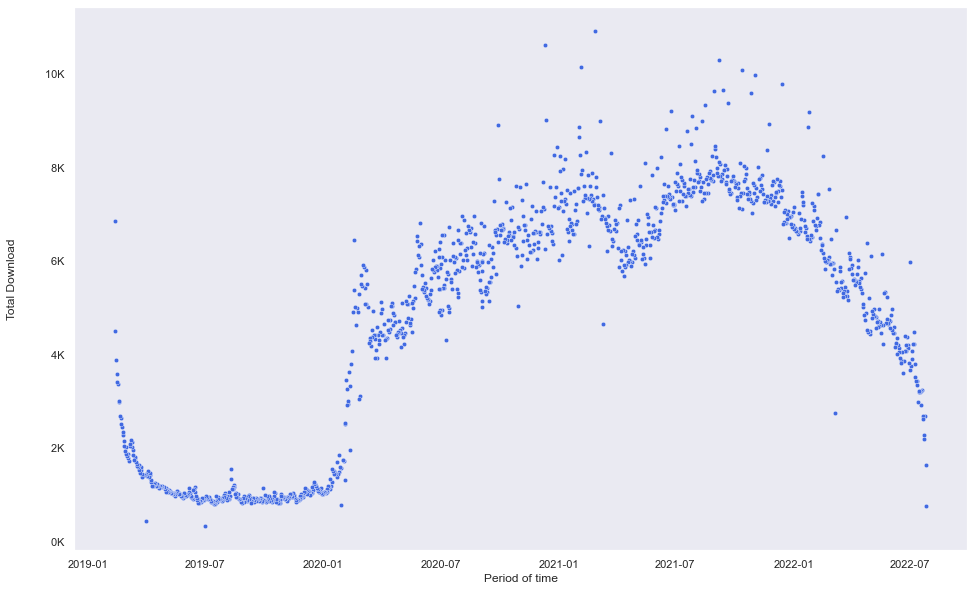

In [63]:
fig, ax = plt.subplots(figsize=(16,10))
sns.scatterplot(x='date' , y='download', data=df, color='royalblue', s = 20)

# plt.grid(True)
plt.xlabel("Period of time")
plt.ylabel("Total Download")
ax.yaxis.set_major_formatter(formatter)

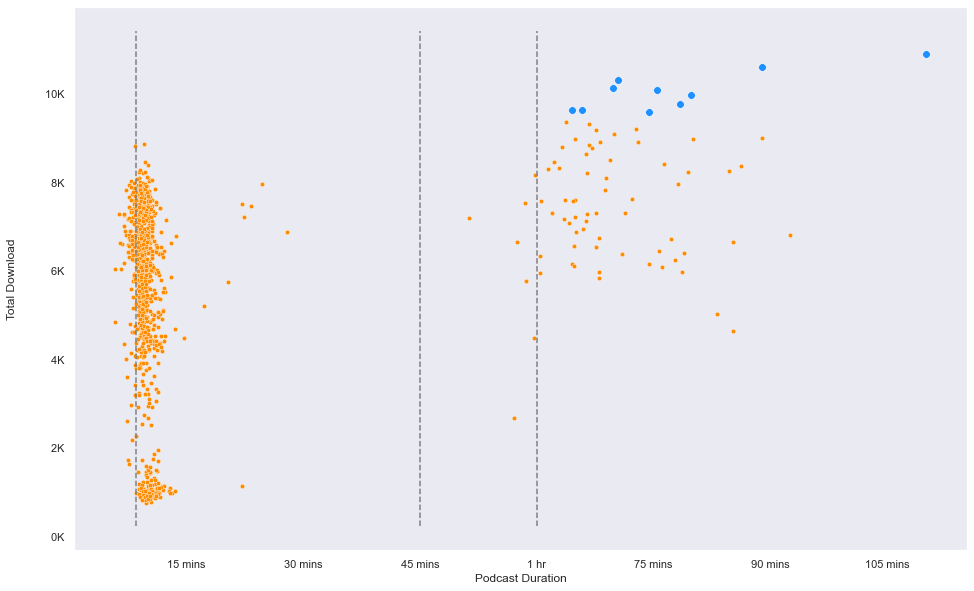

In [66]:
fig, ax = plt.subplots(figsize=(16,10))
p = sns.scatterplot(x='duration_sec' , y='download', data=df, color='darkorange', s = 20)
p
sns.scatterplot(x='duration_sec' , y='download', data=top.head(10), color='dodgerblue', s = 60)

# plt.grid(True)
plt.xlabel("Podcast Duration")
plt.ylabel("Total Download")
ax.yaxis.set_major_formatter(formatter)

# set xticks
p.set_xticks([900, 1800, 2700, 3600, 4500, 5400, 6300, 7200])
p.set_xticklabels(['15 mins', '30 mins', '45 mins', '1 hr', '75 mins', '90 mins', '105 mins', '2 hrs'])

xmin, xmax, ymin, ymax = plt.axis()
plt.vlines(510, ymin=ymin, ymax=ymax, linestyles='dashed', colors=['grey'])
plt.vlines(2700, ymin=ymin, ymax=ymax, linestyles='dashed', colors=['grey'])
plt.vlines(3600, ymin=ymin, ymax=ymax, linestyles='dashed', colors=['grey'])

plt.show()

---